<h1 style="display: flex; align-items: center; font-size: 35px">
    <img src="../assets/icons/icons8-clickteam-fusion-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>MRI Brain Alzheimer Classification - Model Ensemble</strong>
</h1>

****

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-git-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Clone Repository from GitHub
</h1>


In [1]:
# Clone repository from GitHub
# !git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification

# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Brain_Alzheimer_Classification


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-import-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Import Packages
</h1>


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
import gc
import subprocess

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-function-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Import Internal Functions
</h1>


In [3]:
from models import def_models
from utils import utils_funcs
from utils import optuna_search

In [4]:
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()
gc.collect()
utils_funcs.open_nvitop()

torch.cuda.is_available(): True
device: cuda:0


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-load-50.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Load Dataset
</h1>

In [5]:
test_set = torch.load('dataset/dataset_variables/test_set.pt')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Models Definition and Initialization
</h1>

**DINOv2**

In [6]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# Create DINOv2 model with FC layers before the output
dino_v2_model = def_models.DINOv2(DINOv2_backbone=dino_v2_model, output_channels=output_channels).to(device)

pretrained_model_path = f"./checkpoints/DINOv2_atk_225702_10102024/DINOv2_atk_120234_12102024_train_0.2628_val_0.5694.pth"
checkpoint = torch.load(pretrained_model_path,weights_only=True)
dino_v2_model.load_state_dict(checkpoint['net'])

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


<All keys matched successfully>

**EfficientnetB0**

In [7]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

# Load a pre-trained EfficientNet-B0 model
EfficientNet_backbone_model = torchvision.models.efficientnet_b0(pretrained=True)

# Freeze EfficientNet-B0 layers
for param in EfficientNet_backbone_model.parameters():
    param.requires_grad = True

# Create EfficientNet-B0 model with FC layers before the output
efficientnet_model = def_models.EfficientNet(EfficientNet_backbone=EfficientNet_backbone_model, output_channels=output_channels).to(device)

pretrained_model_path = './checkpoints/EfficientNet_atk_105400_26102024/EfficientNet_atk_110930_26102024_train_0.0037_val_0.0601.pth'
checkpoint = torch.load(pretrained_model_path,weights_only=True)
efficientnet_model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

**Resnet**

In [8]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

# Load a pre-trained ResNet34 model
ResNet_backbone_model = torchvision.models.resnet34(pretrained=True)

# Create ResNet34 model with FC layers before the output
resnet_model = def_models.ResNet(ResNet_backbone=ResNet_backbone_model, output_channels=output_channels).to(device)

pretrained_model_path = './checkpoints/ResNet_atk_091635_23102024/ResNet_atk_091635_23102024_train_0.0092_val_0.0940.pth'
checkpoint = torch.load(pretrained_model_path,weights_only=True)
resnet_model.load_state_dict(checkpoint['net'])


<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-loader-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Create Data Loaders
</h1>

In [9]:
batch_size = 64
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-unite-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model Ensemble
</h1>

**Define parameters**

In [10]:
# General parameters
models_group = [dino_v2_model, resnet_model, efficientnet_model]
weights = [0.333,0.333,0.333]

# FGSM parameters
epsilons = [0.005, 0.0005, 0.1, 0.2]

# PGD parameters
alphas = [0.0001, 0.001, 0.0001, 0.0001]
num_iter = 5


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-prediction-50.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Make the Prediction
</h1>

**Natural Images**

In [11]:
ensemble_accuracy = utils_funcs.calculate_ensemble_accuracy(models_group, weights, testloader, device)
print("Ensemble Model Accuracy on Natural Images: {:.3f}%".format(ensemble_accuracy))

Ensemble Model Accuracy on Natural Images: 98.514%


<Figure size 800x600 with 0 Axes>

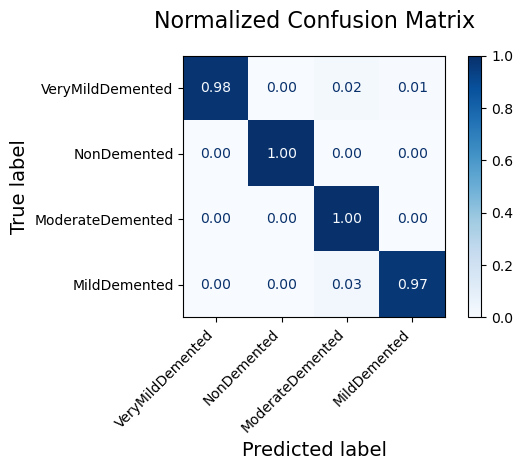

In [12]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_ensemble_confusion_matrix(models_group, weights, testloader, class_names, device)

**Images Under FGSM Attack**

In [63]:
attack_type = 'fgsm'
for epsilon in epsilons:
  ensemble_atk_accuracy = utils_funcs.calculate_ensemble_atk_accuracy(models_group, weights, testloader, device, epsilon=epsilon, attack_type=attack_type)
  print(f"Ensemble Model Accuracy on FGSM with epsilon {epsilon}: {ensemble_atk_accuracy:.3f}%")

Ensemble Model Accuracy on FGSM with epsilon 0.005: 32.604%
Ensemble Model Accuracy on FGSM with epsilon 0.0005: 92.807%
Ensemble Model Accuracy on FGSM with epsilon 0.1: 22.674%
Ensemble Model Accuracy on FGSM with epsilon 0.2: 6.802%


**Images Under PGD Attack**

In [64]:
attack_type = 'pgd'
for epsilon, alpha in zip(epsilons, alphas):
    ensemble_atk_accuracy = utils_funcs.calculate_ensemble_atk_accuracy(models_group, weights, testloader, device, epsilon=epsilon, alpha=alpha, attack_type='pgd', num_iter=num_iter)
    print(f"Ensemble Model Accuracy on PGD with epsilon {epsilon} and alpha {alpha}: {ensemble_atk_accuracy:.3f}%")

Ensemble Model Accuracy on PGD with epsilon 0.005 and alpha 0.0001: 92.181%
Ensemble Model Accuracy on PGD with epsilon 0.0005 and alpha 0.001: 92.338%
Ensemble Model Accuracy on PGD with epsilon 0.1 and alpha 0.0001: 93.901%
Ensemble Model Accuracy on PGD with epsilon 0.2 and alpha 0.0001: 68.804%
